[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/hybrid.ipynb)

In [1]:
import sys
sys.path.append('../')

# Hybrid Classification & Embedding

In this example we'll set up a hybrid ParaDime routine that can both *classify* high-dimensional data and *embed* it in a two dimensional space. Our routine will learn both tasks simultaneously with a shared latent space of the model.

We start by importing some packages and the relevant ParaDime submodules. We also call ParaDime's seed utility for reproducibility reasons.

In [2]:
import copy
import torch
from matplotlib import pyplot as plt

import paradime.dr
import paradime.loss
import paradime.models
import paradime.routines
import paradime.utils

paradime.utils.seed.seed_all(42);

We test our hybrid model on the MNIST handwritten image dataset available via `torchvision`.

In [3]:
import torchvision

mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
num_items = 5000

mnist_subset = mnist_data[:num_items]
target_subset = mnist.targets[:num_items]

## Defining Our Custom Model

Let's now define our hybrid model. In our model's `__init__` we simply create a list of fully connected layers depending on our input and hidden layer dimensions. From the final hidden layer, the model branches out into an embedding part with default dimensionality 2 and another part for classification, which depends on the number of target classes.

In [4]:
class HybridEmbeddingModel(paradime.models.Model):
    """A fully connected network for hybrid embedding and classification.

    Args:
        in_dim: Input dimension.
        hidden_dims: List of hidden layer dimensions.
        num_classes: Number of target classes.
        emb_dim: Embedding dimension (2 by default).        
    """

    def __init__(self,
        in_dim: int,
        hidden_dims: list[int],
        num_classes: int,
        emb_dim: int = 2,
    ):
        super().__init__()

        self.layers = torch.nn.ModuleList()

        cur_dim = in_dim
        for hdim in hidden_dims:
            self.layers.append(torch.nn.Linear(cur_dim, hdim))
            cur_dim = hdim

        self.emb_layer = torch.nn.Linear(cur_dim, emb_dim)
        self.class_layer = torch.nn.Linear(cur_dim, num_classes)

        self.alpha = torch.nn.Parameter(torch.tensor(1.0))

    def common_forward(self, x):
        for layer in self.layers:
            # x = torch.sigmoid(layer(x))
            x = layer(x)
            x = torch.nn.functional.softplus(x)
        return x

    def embed(self, x):
        x = self.common_forward(x)
        x = self.emb_layer(x)
        return x

    def classify(self, x):
        x = self.common_forward(x)
        x = self.class_layer(x)
        return x

The model has a `common_forward` method, which propagates the input until the final hidden layer. It also has an `embed` method that takes the common forward output (i.e., latent representation) and embeds it, and a `classify` method that takes the same representation and turns it into prediction scores.

## Defining the ParaDime Routine

Now we can define our ParaDime routine. We'll borrow most settings from ParaDime's built-in [ParametricTSNE](../api/modules.rst#paradime.routines.ParametricTSNE) class.

To do this, we first define a dummy parametric TSNE routine:

In [5]:
tsne = paradime.routines.ParametricTSNE(in_dim=28*28)

Now we can acces our dummy method's relations, training phases, and the main embedding loss:

In [6]:
global_rel = tsne.global_relations
batch_rel = tsne.batch_relations
init_phase, main_phase = tsne.training_phases
rel_loss = main_phase.loss

With these building blocks, we can go on to define our routine. In the following cell, quite a lot of things happen. Let's break it down one by one:

- First we define a list of weights, which we will later use in a compound loss to run a bunch of experiments at once.
- Then we set up a dictionary of losses containing the original t-SNE loss and a simple classification loss. Because we implemented our custom model with a `classify` method, we don't have to specify anything else in the classification loss.
- We're ready to define our `hybrid_tsne` routine now. As a model we use our `HybridEmbeddingModel`. The rest of the settings are the ones we copied from the built-in class above.
- We add a training phase to the routine that uses both losses with the corresponding weights. To this end, we pass the respective settings to the `loss_keys` and `loss_weights` parameters.
- Finally, we can call the routine's `train` method, making sure to supply the main data and the required class labels.

The three blocks of code that follow the training are just there for saving the embedded MNIST subsets and our classifier's accuracies for each weight.

In [11]:
embeddings = []
train_accuracies = []
test_accuracies = []

weights = [0.0, 5.0, 20.0, 50.0, 100.0, 200.0, 300.0, 500.0]

losses = {"tsne": rel_loss, "class": paradime.loss.ClassificationLoss()}

for w in weights:

    paradime.utils.logging.log(f"Weight: {w}")

    hybrid_tsne = paradime.dr.ParametricDR(
        model=HybridEmbeddingModel(
            in_dim=28 * 28, hidden_dims=[100, 50], num_classes=10, emb_dim=2, 
        ),
        global_relations=global_rel,
        batch_relations=batch_rel,
        losses=losses,
        use_cuda=True,
        verbose=True,
    )
    hybrid_tsne.add_training_phase(
        epochs=50,
        batch_size=500,
        learning_rate=0.001,
        loss_keys=["tsne", "class"],
        loss_weights=[w, 1.0],
    )
    hybrid_tsne.train({
        "main": mnist_subset,
        "labels": target_subset,
    })

    embeddings.append(hybrid_tsne.apply(mnist_subset, "embed"))

    train_logits = hybrid_tsne.apply(mnist_subset, "classify")
    train_prediction = torch.argmax(train_logits, dim=1)
    train_accuracies.append(
        torch.sum(train_prediction == target_subset) / num_items
    )

    test_logits = hybrid_tsne.apply(
        mnist_data[num_items : 2 * num_items], "classify"
    )
    test_prediction = torch.argmax(test_logits, dim=1)
    test_accuracies.append(
        torch.sum(test_prediction == mnist.targets[num_items : 2 * num_items])
        / num_items
    )


2022-12-05 17:35:57,037: Weight: 0.0
2022-12-05 17:35:57,053: Initializing training dataset.
2022-12-05 17:35:57,054: Computing global relations 'rel'.
2022-12-05 17:35:57,055: Indexing nearest neighbors.
2022-12-05 17:36:00,495: Calculating probabilities.
2022-12-05 17:36:00,899: Beginning training phase 'None'.
2022-12-05 17:36:01,524: Loss after epoch 0: 23.374043226242065
2022-12-05 17:36:04,791: Loss after epoch 5: 6.746389925479889
2022-12-05 17:36:07,537: Loss after epoch 10: 3.327723205089569
2022-12-05 17:36:10,121: Loss after epoch 15: 2.488990306854248
2022-12-05 17:36:12,493: Loss after epoch 20: 2.063904419541359
2022-12-05 17:36:14,884: Loss after epoch 25: 1.7633165121078491
2022-12-05 17:36:17,302: Loss after epoch 30: 1.5405211821198463
2022-12-05 17:36:19,748: Loss after epoch 35: 1.3202617168426514
2022-12-05 17:36:22,149: Loss after epoch 40: 1.1230880618095398
2022-12-05 17:36:24,618: Loss after epoch 45: 0.9901934340596199
2022-12-05 17:36:26,575: Weight: 5.0
2022

## Plotting the Results

Once the training has completed (which might take while, since we train 8 different routines from scratch), we can take a look at the results.

ParaDime's `scatterplot` utility function accepts an `ax` keyword parameter. We can create a grid of Matplotlib axes and, in a loop, pass each axis as `ax` to create the scatterplot inside the grid. To the final grid cell we add a plot of the accuracies as a function of the losses' weights:

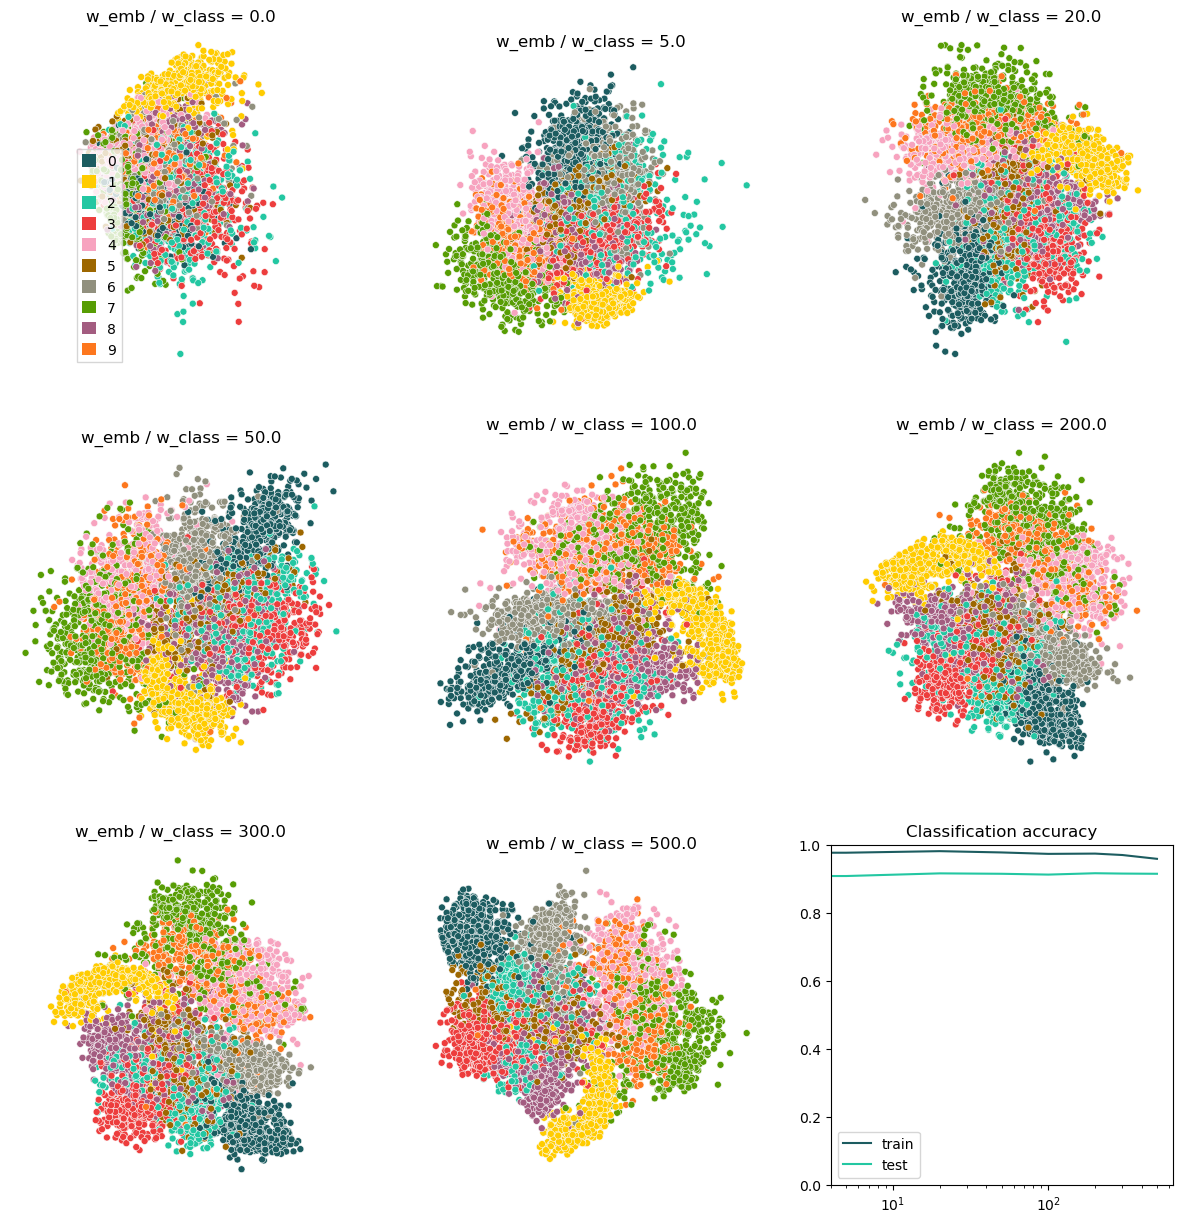

In [13]:
fig = plt.figure(figsize=(15, 15))

for i, (emb, w) in enumerate(zip(embeddings, weights)):
    ax = fig.add_subplot(3, 3, i + 1)

    paradime.utils.plotting.scatterplot(
        emb,
        labels=target_subset,
        ax=ax,
        legend=(i == 0),
        legend_options={"loc": 3},
    )
    ax.set_title(f"w_emb / w_class = {w}")

palette = paradime.utils.plotting.get_color_palette()
ax = fig.add_subplot(3, 3, 9)
ax.plot(weights, train_accuracies, c=palette["petrol"])
ax.plot(weights, test_accuracies, c=palette["aqua"])
ax.set_xscale("log")
ax.set_ylim([0,1])
ax.legend(["train", "test"])
ax.set_title("Classification accuracy");

The plot in the top left corner shows the embedding of the latent space for pure classification. While the embedding function is random here (because the embedding branch of our model was not trained at all), we can still see some clusters because our model has learned to group classes together in the latent space. With increasing weight on the embedding loss, the plot starts to look more like we would expect a t-SNE of MNIST to look like. Despite this, the classification accuracy remains high, as cen be seen in the accuracy plot on the bottom right. Only for very high weights of the embedding loss, the train accuracy drops. Interetingly though, the test accuracy ramains stable (maybe even increasing ever so slightly). This means that the strong focus on embedding does not hurt the classifier to generalize at all.

In summary, we have succesfully trained a model that can perform both tasks, classification *and* t-SNE-like embedding, pretty well.